## Install Vertex AI SDK for Python and other dependencies

In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf

## Restart current kernel

In [7]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:

# Initialize Vertex AI
import vertexai
import subprocess

PROJECT_ID = ""
LOCATION = "us-central1"

PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [2]:
# Import libraries

from IPython.display import Markdown, display
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)

In [3]:
# Load the Gemini models

text_model = GenerativeModel("gemini-1.0-pro")
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

## Split large pdf into parts

In [2]:
! pip3 install PyPDF2

In [15]:
from PyPDF2 import PdfReader, PdfWriter

def split_pdf_by_pages(input_filename, output_prefix="split_", pages_per_part=10):
  """
  Splits a PDF file into multiple parts with a specified number of pages per part.

  Args:
      input_filename (str): Path to the input PDF file.
      output_prefix (str, optional): Prefix for the output filenames. Defaults to "split_".
      pages_per_part (int, optional): Number of pages per output PDF. Defaults to 50.
  """
  reader = PdfReader(input_filename)
  num_pages = len(reader.pages)

  part_num = 1
  writer = PdfWriter()

  for page_num in range(num_pages):
    page = reader.pages[page_num]
    writer.add_page(page)

    # Check if we reached the desired pages per part or it's the last page
    if (page_num + 1) % pages_per_part == 0 or page_num == num_pages - 1:
      output_filename = f"{output_prefix}{part_num}.pdf"
      with open(output_filename, 'wb') as output_file:
        writer.write(output_file)
      writer = PdfWriter()
      part_num += 1

  print(f"PDF split into {part_num - 1} parts.")

# Example usage
split_pdf_by_pages("distributed-sql-for-dummies_ebook_1159.pdf", "output_", 10)  # Split into parts with 10 pages each

PDF split into 6 parts.


In [3]:
# Download custom modules and utilities

import os
import urllib.request
import sys

if not os.path.exists("utils"):
    os.makedirs("utils")


# download the helper scripts from utils folder
url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/"
files = ["intro_multimodal_rag_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")

In [5]:
from utils.intro_multimodal_rag_utils import get_document_metadata

In [6]:
# Specify the PDF folder with multiple PDF

# pdf_folder_path = "/content/data/" # if running in Google Colab/Colab Enterprise
pdf_folder_path = "data/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing gemini 1.0 pro vision model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- data/output_4.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/output_4.pdf_image_0_0_53.jpeg
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Processing page: 8
Processing page: 9
Processing page: 10


 Processing the file: --------------------------------- data/output_3.pdf 


Processing page: 1
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Extracting image from page: 7, saved as: images/output_3.pdf_image_6_0_117.jpeg
Processing page: 8
Extracting image from page: 8, saved as: images/output_3.pdf_image_7_0_122.jpeg
Processing page: 9
Processing page: 10


 Processing the file: --------------------------------- data/output_5.pdf 


Processing page: 1
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Processin

In [7]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,output_4.pdf,1,"26 Distributed SQL For Dummies, MariaDB S...","[0.010887818410992622, -0.010059181600809097, ...",1,"26 Distributed SQL For Dummies, MariaDB S...","[0.015333144925534725, -0.01221971120685339, -..."
1,output_4.pdf,1,"26 Distributed SQL For Dummies, MariaDB S...","[0.010887818410992622, -0.010059181600809097, ...",2,more \nefficient to distribute these tables to...,"[-0.007647314574569464, -0.006617014296352863,..."
2,output_4.pdf,2,CHAPTER 3 Getting Started with Distributed SQ...,"[0.007739322260022163, -0.0328284315764904, -0...",1,CHAPTER 3 Getting Started with Distributed SQ...,"[-0.0011203080648556352, -0.016833297908306122..."
3,output_4.pdf,2,CHAPTER 3 Getting Started with Distributed SQ...,"[0.007739322260022163, -0.0328284315764904, -0...",2,for a single column or for a set of \ncolumns...,"[0.006389744114130735, -0.0648793876171112, -0..."
4,output_4.pdf,3,"28 Distributed SQL For Dummies, MariaDB S...","[0.03975343331694603, -0.026038499549031258, -...",1,"28 Distributed SQL For Dummies, MariaDB S...","[0.03797740861773491, -0.02626730315387249, -0..."


In [8]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_img_only,text_embedding_from_image_description
0,output_4.pdf,1,1,images/output_4.pdf_image_0_0_53.jpeg,"The image shows two tables named ""Person"" and...","[-0.0011343034, 0.021069074, -0.00591195328, 0...","[-0.02138368971645832, -0.0374026894569397, -0..."
1,output_3.pdf,7,1,images/output_3.pdf_image_6_0_117.jpeg,This is a screenshot of a page in the IBM Clo...,"[-0.0264532715, 0.0122436155, -0.0349523574, 0...","[0.03647655248641968, -0.03664838522672653, -0..."
2,output_3.pdf,8,1,images/output_3.pdf_image_7_0_122.jpeg,This is a screenshot of a database connection...,"[-0.0230438225, 0.0173334237, 0.000806792232, ...","[0.018998736515641212, -0.04227399453520775, -..."
3,output_2.pdf,5,1,images/output_2.pdf_image_4_0_76.jpeg,The image shows a table with 5 columns and 11...,"[-0.00133756071, 0.0443274938, 0.00827090908, ...","[0.003175361081957817, -0.0176668893545866, -0..."
4,output_2.pdf,6,1,images/output_2.pdf_image_5_0_86.jpeg,"The image shows a table called ""My Big Table""...","[0.0436883941, 0.0152015463, -0.0231184382, 0....","[-0.009739933535456657, -0.006985212676227093,..."


## Import the helper functions to implement RAG

In [9]:
from utils.intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

In [11]:
# pdf_folder_path = "/content/data/" # if running in Google Colab/Colab Enterprise
pdf_folder_path = "data/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

# Extract text metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing gemini 1.0 pro model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- data/output_4.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/output_4.pdf_image_0_0_53.jpeg
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Processing page: 8
Processing page: 9
Processing page: 10


 Processing the file: --------------------------------- data/output_3.pdf 


Processing page: 1
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Extracting image from page: 7, saved as: images/output_3.pdf_image_6_0_117.jpeg
Processing page: 8
Extracting image from page: 8, saved as: images/output_3.pdf_image_7_0_122.jpeg
Processing page: 9
Processing page: 10


 Processing the file: --------------------------------- data/output_5.pdf 


Processing page: 1
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Processin

In [12]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,output_4.pdf,1,"26 Distributed SQL For Dummies, MariaDB S...","[0.010887818410992622, -0.010059181600809097, ...",1,"26 Distributed SQL For Dummies, MariaDB S...","[0.015333144925534725, -0.01221971120685339, -..."
1,output_4.pdf,1,"26 Distributed SQL For Dummies, MariaDB S...","[0.010887818410992622, -0.010059181600809097, ...",2,more \nefficient to distribute these tables to...,"[-0.007647314574569464, -0.006617014296352863,..."
2,output_4.pdf,2,CHAPTER 3 Getting Started with Distributed SQ...,"[0.007739322260022163, -0.0328284315764904, -0...",1,CHAPTER 3 Getting Started with Distributed SQ...,"[-0.0011203080648556352, -0.016833297908306122..."
3,output_4.pdf,2,CHAPTER 3 Getting Started with Distributed SQ...,"[0.007739322260022163, -0.0328284315764904, -0...",2,for a single column or for a set of \ncolumns...,"[0.006389744114130735, -0.0648793876171112, -0..."
4,output_4.pdf,3,"28 Distributed SQL For Dummies, MariaDB S...","[0.03975343331694603, -0.026038499549031258, -...",1,"28 Distributed SQL For Dummies, MariaDB S...","[0.03797740861773491, -0.02626730315387249, -0..."


In [13]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_img_only,text_embedding_from_image_description
0,output_4.pdf,1,1,images/output_4.pdf_image_0_0_53.jpeg,The image shows a relational database with th...,"[-0.00113406091, 0.0210696179, -0.0059121442, ...","[-0.019511105492711067, -0.05309029296040535, ..."
1,output_3.pdf,7,1,images/output_3.pdf_image_6_0_117.jpeg,The image shows a screenshot of a database se...,"[-0.0264538694, 0.0122389272, -0.0349519588, 0...","[0.02438773401081562, -0.031891003251075745, -..."
2,output_3.pdf,8,1,images/output_3.pdf_image_7_0_122.jpeg,This is a screenshot of a database connection...,"[-0.0230438225, 0.0173334237, 0.000806792232, ...","[0.015206360258162022, -0.03694455325603485, -..."
3,output_2.pdf,5,1,images/output_2.pdf_image_4_0_76.jpeg,The image shows a table with 5 columns and 11...,"[-0.00133756071, 0.0443274938, 0.00827090908, ...","[0.003175361081957817, -0.0176668893545866, -0..."
4,output_2.pdf,6,1,images/output_2.pdf_image_5_0_86.jpeg,"The image shows a table called ""My Big Table""...","[0.0436886437, 0.0152017204, -0.0231184252, 0....","[0.0007865345687605441, 0.0032267244532704353,..."


In [18]:
query = """Questions:
 - What are the topologies of distributed sql?
 - When to use distributed sql?
 - What are the challenges of distributed sql?
 - What are some ways to optimize distributed sql?
 - How does indexing work in distributed sql?
 - What key concepts differentiate distributed sql from regular sql?
 """

In [19]:
# Matching user text query with "chunk_embedding" to find relevant chunks.


matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)

# Print the matched text citations
print_text_to_text_citation(matching_results_chunks_data, print_top=True, chunk_text=True)

Citation 1: Matched text: 

score:  0.81
file_name:  output_5.pdf
page_number:  8
chunk_number:  1
chunk_text:  CHAPTER 5  Deciding if Distributed SQL Is Right for You      43
These materials are  2023 John Wiley & Sons, Inc. Any dissemination, distribution, or unauthorized use is strictly prohibited.
Chapter5
IN THIS CHAPTER

 Considering if distributed SQL is the 
solution

 Needing distributed SQL
Deciding if Distributed 
SQL Is Right for You
D
istributed SQL databases may not be the right solution for 
every application. This chapter helps you consider when a 
distributed SQL database is the correct application technol-
ogy and its not.
Determining When Distributed  
SQL Isnt the Answer
Distributed SQL is a powerful solution but not every awesome 
technology meets the specific needs of your business. Here are a 
few reasons not to consider distributed SQL:

 When you have many small tables: Distributed SQL 
databases are designed for scale. Complex small data 
doesnt perform as wel

In [20]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

In [21]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )

In [22]:
prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}
 - Image Context:
 {context_images}


{query}

Answer:
"""

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        text_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=0.4, max_output_tokens=2048),
    )
)

## Analyzing the Context:

Based on the provided text and image context, here's how I will answer the questions:

**1. What are the topologies of distributed SQL?**

* **Shared-nothing architecture:** Each node has its own local storage and does not share data with other nodes. This architecture is more scalable and can provide better performance, but it is more complex to implement and manage.
* **Shared-disk architecture:** All nodes can access the same data on a shared storage device. This architecture is simpler to implement and manage, but it can be less scalable and can have performance issues if there is a lot of contention for the shared storage device.

**2. When to use distributed SQL?**

* When you have a large database that is too big for a single server to handle.
* When you need high availability and scalability.
* When you need to perform complex queries that involve joining data from multiple tables.

**3. What are the challenges of distributed SQL?**

* **Complexity:** Distributed SQL systems are more complex to set up and manage than traditional SQL databases.
* **Data consistency:** Ensuring data consistency across multiple nodes can be challenging.
* **Transaction management:** Managing transactions across multiple nodes can be complex.
* **Performance:** Distributed SQL systems can have higher latency than traditional SQL databases.

**4. What are some ways to optimize distributed SQL?**

* **Choose the right topology:** The shared-nothing architecture is generally more scalable than the shared-disk architecture.
* **Use proper indexing:** Indexing can improve the performance of queries.
* **Denormalize data:** Denormalizing data can reduce the number of joins that need to be performed.
* **Use a distributed query optimizer:** A distributed query optimizer can help to optimize the execution plan for queries.

**5. How does indexing work in distributed SQL?**

Indexing in distributed SQL works in a similar way to indexing in traditional SQL databases. Indexes are used to speed up the execution of queries by allowing the database to quickly find the data that it needs. However, in distributed SQL, the indexes are distributed across multiple nodes.

**6. What key concepts differentiate distributed SQL from regular SQL?**

* **Data distribution:** Distributed SQL databases distribute data across multiple nodes.
* **Parallel query execution:** Distributed SQL databases can execute queries in parallel across multiple nodes.
* **Data consistency:** Distributed SQL databases need to ensure data consistency across multiple nodes.
* **Transaction management:** Distributed SQL databases need to manage transactions across multiple nodes.

## Answering the Questions:

**1. What are the topologies of distributed SQL?**

There are two main topologies for distributed SQL: shared-nothing and shared-disk. In a shared-nothing architecture, each node has its own local storage and does not share data with other nodes. This architecture is more scalable and can provide better performance, but it is more complex to implement and manage. In a shared-disk architecture, all nodes can access the same data on a shared storage device. This architecture is simpler to implement and manage, but it can be less scalable and can have performance issues if there is a lot of contention for the shared storage device.

**2. When to use distributed SQL?**

Distributed SQL is a good choice for applications that require high availability, scalability, and the ability to perform complex queries. It is also a good choice for applications that have a large amount of data.

**3. What are the challenges of distributed SQL?**

The main challenges of distributed SQL are complexity, data consistency, transaction management, and performance. Distributed SQL systems are more complex to set up and manage than traditional SQL databases. Ensuring data consistency across multiple nodes can be challenging. Managing transactions across multiple nodes can be complex. Distributed SQL systems can have higher latency than traditional SQL databases.

**4. What are some ways to optimize distributed SQL?**

There are several ways to optimize distributed SQL, including choosing the right topology, using proper indexing, denormalizing data, and using a distributed query optimizer.

**5. How does indexing work in distributed SQL?**

Indexing in distributed SQL works in a similar way to indexing in traditional SQL databases. Indexes are used to speed up the execution of queries by allowing the database to quickly find the data that it needs. However, in distributed SQL, the indexes are distributed across multiple nodes.

**6. What key concepts differentiate distributed SQL from regular SQL?**

The key concepts that differentiate distributed SQL from regular SQL are data distribution, parallel query execution, data consistency, and transaction management. Distributed SQL databases distribute data across multiple nodes. Distributed SQL databases can execute queries in parallel across multiple nodes. Distributed SQL databases need to ensure data consistency across multiple nodes. Distributed SQL databases need to manage transactions across multiple nodes.

---------------Matched Images------------------



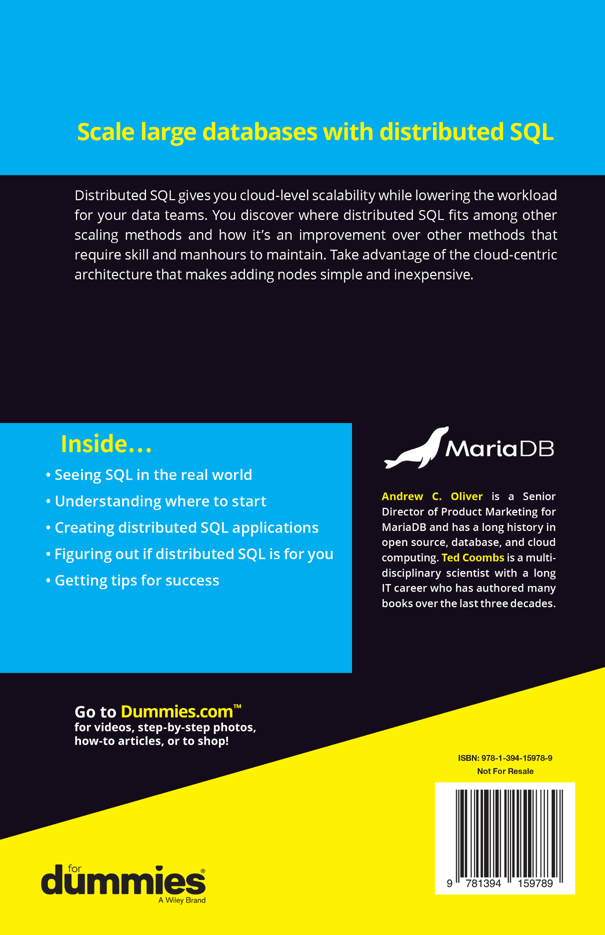

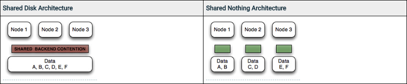

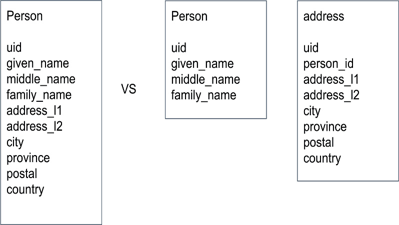

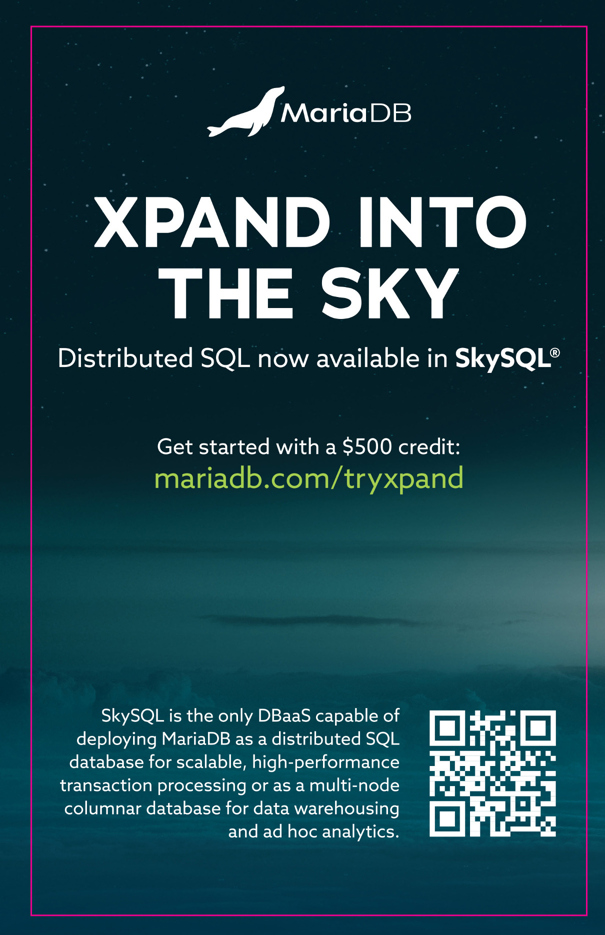

In [23]:
print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_fromdescription_data[0]["img_path"],
        matching_results_image_fromdescription_data[1]["img_path"],
        matching_results_image_fromdescription_data[2]["img_path"],
        matching_results_image_fromdescription_data[3]["img_path"],
    ],
    resize_ratio=0.5,
)

In [24]:
# Image citations. You can check how Gemini generated metadata helped in grounding the answer.

print_text_to_image_citation(
    matching_results_image_fromdescription_data, print_top=False
)

Citation 1: Matched image path, page number and page text: 

score:  0.77
file_name:  output_6.pdf
path:  images/output_6.pdf_image_7_0_133.jpeg
page number:  8
page text:  
image description:   The image is an advertisement for a book titled "Scale Large Databases with Distributed SQL". The book is written by Andrew C. Oliver and Ted Coombs. The book is published by Dummies. The book has a list of topics that will be covered in the book. The topics are:
* Seeing SQL in the real world
* Understanding where to start
* Creating distributed SQL applications
* Figuring out if distributed SQL is for you
* Getting tips for success
Citation 2: Matched image path, page number and page text: 

score:  0.73
file_name:  output_2.pdf
path:  images/output_2.pdf_image_6_0_89.jpeg
page number:  7
page text:  CHAPTER 1  Getting to Know Distributed SQL      11
These materials are  2023 John Wiley & Sons, Inc. Any dissemination, distribution, or unauthorized use is strictly prohibited.
Balancing the loa